In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import numpy as np
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

In [3]:
def model_input(state_size):
    #states = tf.placeholder(tf.float32, [None, *state_size], name='states')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    rates = tf.placeholder(tf.float32, [None], name='rates')
    return states, actions, targetQs, rates

In [4]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [5]:
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=action_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        nl1_fused = tf.concat(axis=1, values=[nl1, actions])
        h2 = tf.layers.dense(inputs=nl1_fused, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
                
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [17]:
def model_loss(action_size, hidden_size, states, actions, targetQs, rates):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    gQs = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states)
    rates = tf.reshape(rates, shape=[-1, 1])
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                   labels=rates)) # 0-1
    targetQs = tf.reshape(targetQs, shape=[-1, 1])
    gloss += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                    labels=tf.nn.sigmoid(targetQs))) # 0-1
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    dQs = discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    dlossA = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                    labels=rates)) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=dQs, # GAN
                                                                     labels=tf.nn.sigmoid(targetQs))) # 0-1
    dlossA += tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=gQs, # GAN
                                                                     labels=tf.zeros_like(targetQs))) # 0-1
    dlossQ = tf.reduce_mean(tf.square(gQs - targetQs)) # DQN
    dlossQ = tf.reduce_mean(tf.square(dQs - targetQs)) # DQN
    dlossQ /= 2
    return actions_logits, gQs, gloss, dlossA, dlossQ

In [28]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_lossA, d_lossQ, g_learning_rate, d_learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(g_learning_rate).minimize(g_loss, var_list=g_vars)
        d_optA = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossA, var_list=d_vars)
        d_optQ = tf.train.AdamOptimizer(d_learning_rate).minimize(d_lossQ, var_list=d_vars)

    return g_opt, d_optA, d_optQ

In [19]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, g_learning_rate, d_learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.rates = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_lossA, self.d_lossQ = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, 
            targetQs=self.targetQs, rates=self.rates) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_optA, self.d_optQ = model_opt(g_loss=self.g_loss, 
                                                         d_lossA=self.d_lossA, 
                                                         d_lossQ=self.d_lossQ, 
                                                         g_learning_rate=g_learning_rate, 
                                                         d_learning_rate=d_learning_rate)

In [20]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size) # data batch
        self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), # ==  self.rates
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [21]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [22]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 4*2             # number of units in each Q-network hidden layer
g_learning_rate = 1e-4         # Q-network learning rate
d_learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e3)             # experience mini-batch size: 200/500 a successfull episode size
gamma = 0.99                   # future reward discount

In [23]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, state_size=state_size, hidden_size=hidden_size,
              g_learning_rate=g_learning_rate, d_learning_rate=d_learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

In [24]:
state = env.reset()
total_reward = 0
num_step = 0
for _ in range(memory_size):
    action = env.action_space.sample()
    next_state, reward, done, _ = env.step(action)
    memory.buffer.append([state, action, next_state, reward, float(done)])
    memory.rates.append(-1) # empty
    num_step += 1 # memory incremented
    total_reward += reward
    state = next_state
    if done is True:
        state = env.reset()
        rate = total_reward/500
        total_reward = 0 # reset
        for idx in range(num_step): # episode length
            if memory.rates[-1-idx] == -1:
                memory.rates[-1-idx] = rate
        num_step = 0 # reset

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [25]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list = [] # goal
rewards_list, gloss_list, dloss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

    # Training episodes/epochs
    for ep in range(1111*3):
        total_reward = 0 # each episode
        gloss_batch, dlossA_batch, dlossQ_batch= [], [], []
        state = env.reset() # each episode
        num_step = 0 # each episode
        idx_arr = np.arange(memory_size// batch_size)

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
                #print(action)
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits) # adding epsilon*noise
                #print(action)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done)])
            memory.rates.append(-1) # empty
            num_step += 1 # momory added
            total_reward += reward
            state = next_state
            
            # Rating the memory
            if done is True:
                rate = total_reward/500 # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.rates[-1-idx] == -1: # double-check the landmark/marked indexes
                        memory.rates[-1-idx] = rate # rate the trajectory/data
                        
            # Training with the maxrated minibatch
            batch = memory.buffer
            percentage = 0.9
            #for idx in range(memory_size// batch_size):
            idx = np.random.choice(idx_arr)
            states = np.array([each[0] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])[idx*batch_size:(idx+1)*batch_size]
            rates = np.array(memory.rates)[idx*batch_size:(idx+1)*batch_size]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            states = states[rates >= (np.max(rates)*percentage)]
            actions = actions[rates >= (np.max(rates)*percentage)]
            next_states = next_states[rates >= (np.max(rates)*percentage)]
            rewards = rewards[rates >= (np.max(rates)*percentage)]
            dones = dones[rates >= (np.max(rates)*percentage)]
            rates = rates[rates >= (np.max(rates)*percentage)]
            #print(states.shape, actions.shape, next_states.shape, rewards.shape, dones.shape, rates.shape)
            nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            #nextQs = np.max(nextQs_logits, axis=1) * (1-dones) # DQN
            nextQs = nextQs_logits.reshape([-1]) * (1-dones) # DPG
            targetQs = rewards + (gamma * nextQs)
            dlossA, dlossQ, _ = sess.run([model.d_lossA, model.d_lossQ, model.d_optA], #, model.d_optQ
                                         feed_dict = {model.states: states, 
                                                      model.actions: actions,
                                                      model.targetQs: targetQs, 
                                                      model.rates: rates})
            gloss, _ = sess.run([model.g_loss, model.g_opt], #, model.d_optQ
                                feed_dict = {model.states: states, 
                                             model.actions: actions,
                                             model.targetQs: targetQs, 
                                             model.rates: rates})
            gloss_batch.append(gloss)
            dlossA_batch.append(dlossA)
            dlossQ_batch.append(dlossQ)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{:.4f}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'gloss:{:.4f}'.format(np.mean(gloss_batch)),
              'dlossA:{:.4f}'.format(np.mean(dlossA_batch)),
              'dlossQ:{:.4f}'.format(np.mean(dlossQ_batch)),
              'exploreP:{:.4f}'.format(explore_p))

        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        #gloss_list.append([ep, np.mean(gloss_batch)])
        #dloss_list.append([ep, np.mean(dloss_batch)])
        
        # Break episode/epoch loop
        ## Option 1: Solve the First Version
        #The task is episodic, and in order to solve the environment, 
        #your agent must get an average score of +30 over 100 consecutive episodes.
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:15.0000 R:15.0000 rate:0.0300 gloss:1.3733 dlossA:2.0080 dlossQ:0.6292 exploreP:0.9985
Episode:1 meanR:18.5000 R:22.0000 rate:0.0440 gloss:1.3716 dlossA:2.0045 dlossQ:0.6260 exploreP:0.9963
Episode:2 meanR:27.6667 R:46.0000 rate:0.0920 gloss:1.3671 dlossA:1.9789 dlossQ:0.6259 exploreP:0.9918
Episode:3 meanR:26.2500 R:22.0000 rate:0.0440 gloss:1.3599 dlossA:1.9549 dlossQ:0.6288 exploreP:0.9897
Episode:4 meanR:26.6000 R:28.0000 rate:0.0560 gloss:1.3581 dlossA:1.9432 dlossQ:0.6227 exploreP:0.9869
Episode:5 meanR:24.1667 R:12.0000 rate:0.0240 gloss:1.3585 dlossA:1.9491 dlossQ:0.6225 exploreP:0.9857
Episode:6 meanR:22.2857 R:11.0000 rate:0.0220 gloss:1.3611 dlossA:1.9644 dlossQ:0.6244 exploreP:0.9847
Episode:7 meanR:21.7500 R:18.0000 rate:0.0360 gloss:1.3452 dlossA:1.9057 dlossQ:0.6172 exploreP:0.9829
Episode:8 meanR:21.4444 R:19.0000 rate:0.0380 gloss:1.3492 dlossA:1.9101 dlossQ:0.6191 exploreP:0.9811
Episode:9 meanR:21.5000 R:22.0000 rate:0.0440 gloss:1.3487 dlossA:1.9030 

Episode:79 meanR:20.4875 R:23.0000 rate:0.0460 gloss:1.2449 dlossA:1.5797 dlossQ:0.6373 exploreP:0.8503
Episode:80 meanR:20.4198 R:15.0000 rate:0.0300 gloss:1.2603 dlossA:1.6098 dlossQ:0.6477 exploreP:0.8491
Episode:81 meanR:20.4756 R:25.0000 rate:0.0500 gloss:1.2517 dlossA:1.5895 dlossQ:0.6290 exploreP:0.8470
Episode:82 meanR:20.4699 R:20.0000 rate:0.0400 gloss:1.2416 dlossA:1.5717 dlossQ:0.6309 exploreP:0.8453
Episode:83 meanR:20.3690 R:12.0000 rate:0.0240 gloss:1.2245 dlossA:1.5125 dlossQ:0.6291 exploreP:0.8443
Episode:84 meanR:20.3294 R:17.0000 rate:0.0340 gloss:1.2436 dlossA:1.5638 dlossQ:0.6041 exploreP:0.8429
Episode:85 meanR:20.5814 R:42.0000 rate:0.0840 gloss:1.2334 dlossA:1.5323 dlossQ:0.6386 exploreP:0.8394
Episode:86 meanR:20.5517 R:18.0000 rate:0.0360 gloss:1.2361 dlossA:1.5407 dlossQ:0.5883 exploreP:0.8379
Episode:87 meanR:20.5000 R:16.0000 rate:0.0320 gloss:1.2504 dlossA:1.5790 dlossQ:0.5837 exploreP:0.8366
Episode:88 meanR:20.5618 R:26.0000 rate:0.0520 gloss:1.2217 dlos

Episode:158 meanR:23.4700 R:20.0000 rate:0.0400 gloss:1.1560 dlossA:1.3495 dlossQ:0.5854 exploreP:0.7019
Episode:159 meanR:23.7700 R:41.0000 rate:0.0820 gloss:1.1427 dlossA:1.3255 dlossQ:0.5883 exploreP:0.6991
Episode:160 meanR:23.7800 R:48.0000 rate:0.0960 gloss:1.1673 dlossA:1.3555 dlossQ:0.6686 exploreP:0.6958
Episode:161 meanR:24.1200 R:66.0000 rate:0.1320 gloss:1.1481 dlossA:1.3374 dlossQ:0.5662 exploreP:0.6913
Episode:162 meanR:24.3700 R:37.0000 rate:0.0740 gloss:1.1581 dlossA:1.3441 dlossQ:0.6584 exploreP:0.6888
Episode:163 meanR:24.3500 R:21.0000 rate:0.0420 gloss:1.1462 dlossA:1.3343 dlossQ:0.5583 exploreP:0.6874
Episode:164 meanR:24.8900 R:64.0000 rate:0.1280 gloss:1.1456 dlossA:1.3325 dlossQ:0.5500 exploreP:0.6830
Episode:165 meanR:25.1000 R:35.0000 rate:0.0700 gloss:1.1459 dlossA:1.3303 dlossQ:0.5369 exploreP:0.6807
Episode:166 meanR:25.6800 R:78.0000 rate:0.1560 gloss:1.1438 dlossA:1.3246 dlossQ:0.5421 exploreP:0.6755
Episode:167 meanR:26.2200 R:70.0000 rate:0.1400 gloss:1

Episode:237 meanR:30.7400 R:11.0000 rate:0.0220 gloss:1.1138 dlossA:1.2773 dlossQ:0.5765 exploreP:0.5445
Episode:238 meanR:30.7300 R:12.0000 rate:0.0240 gloss:1.1283 dlossA:1.2879 dlossQ:0.5672 exploreP:0.5438
Episode:239 meanR:30.7000 R:9.0000 rate:0.0180 gloss:1.1396 dlossA:1.3072 dlossQ:0.5323 exploreP:0.5434
Episode:240 meanR:30.6700 R:16.0000 rate:0.0320 gloss:1.1189 dlossA:1.2803 dlossQ:0.5501 exploreP:0.5425
Episode:241 meanR:30.6300 R:13.0000 rate:0.0260 gloss:1.1132 dlossA:1.2715 dlossQ:0.5556 exploreP:0.5418
Episode:242 meanR:30.6300 R:12.0000 rate:0.0240 gloss:1.1071 dlossA:1.2624 dlossQ:0.5772 exploreP:0.5412
Episode:243 meanR:30.3700 R:12.0000 rate:0.0240 gloss:1.1561 dlossA:1.3077 dlossQ:0.6387 exploreP:0.5405
Episode:244 meanR:30.3800 R:19.0000 rate:0.0380 gloss:1.1316 dlossA:1.2931 dlossQ:0.5226 exploreP:0.5395
Episode:245 meanR:30.2300 R:10.0000 rate:0.0200 gloss:1.1168 dlossA:1.2720 dlossQ:0.5397 exploreP:0.5390
Episode:246 meanR:30.0200 R:12.0000 rate:0.0240 gloss:1.

Episode:316 meanR:17.7600 R:15.0000 rate:0.0300 gloss:1.1783 dlossA:1.3678 dlossQ:0.6403 exploreP:0.4804
Episode:317 meanR:17.2700 R:14.0000 rate:0.0280 gloss:1.1268 dlossA:1.3066 dlossQ:0.5849 exploreP:0.4797
Episode:318 meanR:17.0800 R:12.0000 rate:0.0240 gloss:1.1487 dlossA:1.3238 dlossQ:0.5631 exploreP:0.4791
Episode:319 meanR:16.9300 R:11.0000 rate:0.0220 gloss:1.1637 dlossA:1.3397 dlossQ:0.6008 exploreP:0.4786
Episode:320 meanR:16.5600 R:16.0000 rate:0.0320 gloss:1.1584 dlossA:1.3310 dlossQ:0.6087 exploreP:0.4779
Episode:321 meanR:16.3900 R:25.0000 rate:0.0500 gloss:1.1499 dlossA:1.3185 dlossQ:0.5551 exploreP:0.4767
Episode:322 meanR:16.0800 R:13.0000 rate:0.0260 gloss:1.1477 dlossA:1.3124 dlossQ:0.5279 exploreP:0.4761
Episode:323 meanR:15.8800 R:12.0000 rate:0.0240 gloss:1.1356 dlossA:1.2992 dlossQ:0.5213 exploreP:0.4755
Episode:324 meanR:15.8600 R:13.0000 rate:0.0260 gloss:1.1302 dlossA:1.2866 dlossQ:0.5118 exploreP:0.4749
Episode:325 meanR:15.8700 R:22.0000 rate:0.0440 gloss:1

Episode:395 meanR:14.2400 R:16.0000 rate:0.0320 gloss:1.1119 dlossA:1.2574 dlossQ:0.4684 exploreP:0.4306
Episode:396 meanR:14.2600 R:13.0000 rate:0.0260 gloss:1.1312 dlossA:1.2738 dlossQ:0.4629 exploreP:0.4300
Episode:397 meanR:14.1700 R:9.0000 rate:0.0180 gloss:1.1168 dlossA:1.2569 dlossQ:0.4596 exploreP:0.4296
Episode:398 meanR:14.1200 R:9.0000 rate:0.0180 gloss:1.1335 dlossA:1.2721 dlossQ:0.4432 exploreP:0.4293
Episode:399 meanR:14.1100 R:10.0000 rate:0.0200 gloss:1.1212 dlossA:1.2610 dlossQ:0.4643 exploreP:0.4288
Episode:400 meanR:14.1100 R:13.0000 rate:0.0260 gloss:1.1094 dlossA:1.2495 dlossQ:0.4646 exploreP:0.4283
Episode:401 meanR:14.0700 R:11.0000 rate:0.0220 gloss:1.1304 dlossA:1.2688 dlossQ:0.4537 exploreP:0.4278
Episode:402 meanR:14.0800 R:11.0000 rate:0.0220 gloss:1.0969 dlossA:1.2336 dlossQ:0.4325 exploreP:0.4274
Episode:403 meanR:14.1000 R:11.0000 rate:0.0220 gloss:1.1162 dlossA:1.2495 dlossQ:0.4392 exploreP:0.4269
Episode:404 meanR:14.0100 R:11.0000 rate:0.0220 gloss:1.1

Episode:474 meanR:12.4400 R:14.0000 rate:0.0280 gloss:1.0879 dlossA:1.2130 dlossQ:0.4884 exploreP:0.3909
Episode:475 meanR:12.5000 R:19.0000 rate:0.0380 gloss:1.1095 dlossA:1.2238 dlossQ:0.4274 exploreP:0.3902
Episode:476 meanR:12.5000 R:12.0000 rate:0.0240 gloss:1.0747 dlossA:1.2034 dlossQ:0.4623 exploreP:0.3897
Episode:477 meanR:12.5000 R:13.0000 rate:0.0260 gloss:1.1136 dlossA:1.2291 dlossQ:0.4357 exploreP:0.3892
Episode:478 meanR:12.4800 R:10.0000 rate:0.0200 gloss:1.1067 dlossA:1.2261 dlossQ:0.4447 exploreP:0.3888
Episode:479 meanR:12.5000 R:12.0000 rate:0.0240 gloss:1.0794 dlossA:1.2103 dlossQ:0.4828 exploreP:0.3884
Episode:480 meanR:12.5200 R:12.0000 rate:0.0240 gloss:1.1034 dlossA:1.2293 dlossQ:0.4670 exploreP:0.3879
Episode:481 meanR:12.5500 R:15.0000 rate:0.0300 gloss:1.0967 dlossA:1.2255 dlossQ:0.4628 exploreP:0.3874
Episode:482 meanR:12.5100 R:10.0000 rate:0.0200 gloss:1.0866 dlossA:1.2089 dlossQ:0.4502 exploreP:0.3870
Episode:483 meanR:12.4800 R:15.0000 rate:0.0300 gloss:1

Episode:553 meanR:12.5700 R:17.0000 rate:0.0340 gloss:1.1247 dlossA:1.2727 dlossQ:0.4955 exploreP:0.3539
Episode:554 meanR:12.4500 R:11.0000 rate:0.0220 gloss:1.1324 dlossA:1.2782 dlossQ:0.4869 exploreP:0.3535
Episode:555 meanR:12.4900 R:12.0000 rate:0.0240 gloss:1.1416 dlossA:1.2981 dlossQ:0.5328 exploreP:0.3531
Episode:556 meanR:12.5700 R:18.0000 rate:0.0360 gloss:1.1575 dlossA:1.3006 dlossQ:0.4710 exploreP:0.3525
Episode:557 meanR:12.5800 R:14.0000 rate:0.0280 gloss:1.1188 dlossA:1.2617 dlossQ:0.4725 exploreP:0.3520
Episode:558 meanR:12.6700 R:17.0000 rate:0.0340 gloss:1.1326 dlossA:1.2857 dlossQ:0.5085 exploreP:0.3514
Episode:559 meanR:12.7100 R:13.0000 rate:0.0260 gloss:1.1348 dlossA:1.2874 dlossQ:0.4979 exploreP:0.3510
Episode:560 meanR:13.2600 R:69.0000 rate:0.1380 gloss:1.1259 dlossA:1.2839 dlossQ:0.5182 exploreP:0.3486
Episode:561 meanR:13.7700 R:61.0000 rate:0.1220 gloss:1.1432 dlossA:1.3122 dlossQ:0.5777 exploreP:0.3466
Episode:562 meanR:14.5600 R:89.0000 rate:0.1780 gloss:1

Episode:632 meanR:17.5400 R:11.0000 rate:0.0220 gloss:1.1614 dlossA:1.3531 dlossQ:0.5691 exploreP:0.3056
Episode:633 meanR:17.5600 R:12.0000 rate:0.0240 gloss:1.1514 dlossA:1.3441 dlossQ:0.5708 exploreP:0.3053
Episode:634 meanR:17.6200 R:17.0000 rate:0.0340 gloss:1.1738 dlossA:1.3632 dlossQ:0.5572 exploreP:0.3048
Episode:635 meanR:17.6200 R:11.0000 rate:0.0220 gloss:1.1573 dlossA:1.3468 dlossQ:0.5570 exploreP:0.3044
Episode:636 meanR:17.6200 R:10.0000 rate:0.0200 gloss:1.1714 dlossA:1.3607 dlossQ:0.5553 exploreP:0.3042
Episode:637 meanR:17.6300 R:10.0000 rate:0.0200 gloss:1.1430 dlossA:1.3272 dlossQ:0.5449 exploreP:0.3039
Episode:638 meanR:17.6800 R:15.0000 rate:0.0300 gloss:1.1915 dlossA:1.3730 dlossQ:0.5408 exploreP:0.3034
Episode:639 meanR:17.6900 R:11.0000 rate:0.0220 gloss:1.1554 dlossA:1.3343 dlossQ:0.5424 exploreP:0.3031
Episode:640 meanR:17.7400 R:14.0000 rate:0.0280 gloss:1.1483 dlossA:1.3266 dlossQ:0.5276 exploreP:0.3027
Episode:641 meanR:17.8400 R:18.0000 rate:0.0360 gloss:1

Episode:710 meanR:71.5200 R:189.0000 rate:0.3780 gloss:1.3009 dlossA:1.5120 dlossQ:0.5399 exploreP:0.1629
Episode:711 meanR:74.0600 R:266.0000 rate:0.5320 gloss:1.2250 dlossA:1.4340 dlossQ:0.5461 exploreP:0.1589
Episode:712 meanR:78.9500 R:500.0000 rate:1.0000 gloss:1.2671 dlossA:1.4752 dlossQ:0.5481 exploreP:0.1517
Episode:713 meanR:80.9700 R:237.0000 rate:0.4740 gloss:1.2693 dlossA:1.4846 dlossQ:0.5416 exploreP:0.1484
Episode:714 meanR:85.6200 R:500.0000 rate:1.0000 gloss:1.2921 dlossA:1.5114 dlossQ:0.5498 exploreP:0.1416
Episode:715 meanR:89.5700 R:413.0000 rate:0.8260 gloss:1.2949 dlossA:1.5169 dlossQ:0.5395 exploreP:0.1363
Episode:716 meanR:93.0200 R:380.0000 rate:0.7600 gloss:1.2826 dlossA:1.5077 dlossQ:0.5405 exploreP:0.1316
Episode:717 meanR:94.9900 R:325.0000 rate:0.6500 gloss:1.3057 dlossA:1.5287 dlossQ:0.5440 exploreP:0.1277
Episode:718 meanR:97.9600 R:359.0000 rate:0.7180 gloss:1.2986 dlossA:1.5256 dlossQ:0.5444 exploreP:0.1235
Episode:719 meanR:99.8000 R:205.0000 rate:0.41

Episode:788 meanR:171.7600 R:12.0000 rate:0.0240 gloss:1.3208 dlossA:1.5580 dlossQ:0.4632 exploreP:0.0541
Episode:789 meanR:171.3500 R:14.0000 rate:0.0280 gloss:1.3019 dlossA:1.5442 dlossQ:0.4852 exploreP:0.0541
Episode:790 meanR:170.9800 R:16.0000 rate:0.0320 gloss:1.4265 dlossA:1.6630 dlossQ:0.4943 exploreP:0.0540
Episode:791 meanR:170.9500 R:15.0000 rate:0.0300 gloss:1.2216 dlossA:1.4653 dlossQ:0.4714 exploreP:0.0539
Episode:792 meanR:170.5300 R:19.0000 rate:0.0380 gloss:1.3802 dlossA:1.6068 dlossQ:0.4591 exploreP:0.0539
Episode:793 meanR:169.4100 R:27.0000 rate:0.0540 gloss:1.2950 dlossA:1.5311 dlossQ:0.4752 exploreP:0.0537
Episode:794 meanR:168.9600 R:106.0000 rate:0.2120 gloss:1.4051 dlossA:1.6414 dlossQ:0.4836 exploreP:0.0533
Episode:795 meanR:165.8800 R:94.0000 rate:0.1880 gloss:1.3793 dlossA:1.6501 dlossQ:0.5464 exploreP:0.0529
Episode:796 meanR:165.9900 R:87.0000 rate:0.1740 gloss:1.3998 dlossA:1.6902 dlossQ:0.5654 exploreP:0.0525
Episode:797 meanR:164.1600 R:75.0000 rate:0.1

Episode:866 meanR:56.4900 R:11.0000 rate:0.0220 gloss:1.3186 dlossA:1.5644 dlossQ:0.4462 exploreP:0.0406
Episode:867 meanR:55.5900 R:9.0000 rate:0.0180 gloss:1.2549 dlossA:1.5025 dlossQ:0.4490 exploreP:0.0405
Episode:868 meanR:50.7000 R:11.0000 rate:0.0220 gloss:1.5027 dlossA:1.7371 dlossQ:0.4459 exploreP:0.0405
Episode:869 meanR:49.9500 R:9.0000 rate:0.0180 gloss:1.2663 dlossA:1.5158 dlossQ:0.4435 exploreP:0.0405
Episode:870 meanR:49.2900 R:11.0000 rate:0.0220 gloss:1.4183 dlossA:1.6517 dlossQ:0.4573 exploreP:0.0404
Episode:871 meanR:48.7100 R:9.0000 rate:0.0180 gloss:1.3840 dlossA:1.6239 dlossQ:0.4553 exploreP:0.0404
Episode:872 meanR:48.1000 R:11.0000 rate:0.0220 gloss:1.3922 dlossA:1.6263 dlossQ:0.4438 exploreP:0.0404
Episode:873 meanR:47.4900 R:10.0000 rate:0.0200 gloss:1.3614 dlossA:1.5990 dlossQ:0.4465 exploreP:0.0403
Episode:874 meanR:46.9400 R:11.0000 rate:0.0220 gloss:1.4545 dlossA:1.6851 dlossQ:0.4538 exploreP:0.0403
Episode:875 meanR:46.2800 R:11.0000 rate:0.0220 gloss:1.33

Episode:944 meanR:53.4400 R:53.0000 rate:0.1060 gloss:1.3772 dlossA:1.6615 dlossQ:0.5256 exploreP:0.0283
Episode:945 meanR:54.2000 R:86.0000 rate:0.1720 gloss:1.3786 dlossA:1.6596 dlossQ:0.5226 exploreP:0.0281
Episode:946 meanR:55.1300 R:103.0000 rate:0.2060 gloss:1.3433 dlossA:1.6220 dlossQ:0.5421 exploreP:0.0280
Episode:947 meanR:56.1500 R:113.0000 rate:0.2260 gloss:1.3507 dlossA:1.6255 dlossQ:0.5237 exploreP:0.0278
Episode:948 meanR:56.9300 R:91.0000 rate:0.1820 gloss:1.3735 dlossA:1.6448 dlossQ:0.5292 exploreP:0.0276
Episode:949 meanR:57.8500 R:102.0000 rate:0.2040 gloss:1.3909 dlossA:1.6659 dlossQ:0.5261 exploreP:0.0274
Episode:950 meanR:58.8100 R:106.0000 rate:0.2120 gloss:1.3754 dlossA:1.6481 dlossQ:0.5228 exploreP:0.0272
Episode:951 meanR:59.6900 R:98.0000 rate:0.1960 gloss:1.3949 dlossA:1.6682 dlossQ:0.5236 exploreP:0.0271
Episode:952 meanR:60.5300 R:93.0000 rate:0.1860 gloss:1.4049 dlossA:1.6800 dlossQ:0.5259 exploreP:0.0269
Episode:953 meanR:61.2700 R:82.0000 rate:0.1640 glo

Episode:1022 meanR:75.8400 R:78.0000 rate:0.1560 gloss:1.4376 dlossA:1.7134 dlossQ:0.5036 exploreP:0.0205
Episode:1023 meanR:75.3900 R:55.0000 rate:0.1100 gloss:1.3959 dlossA:1.6726 dlossQ:0.5198 exploreP:0.0205
Episode:1024 meanR:74.9600 R:62.0000 rate:0.1240 gloss:1.3738 dlossA:1.6514 dlossQ:0.5052 exploreP:0.0204
Episode:1025 meanR:75.2300 R:123.0000 rate:0.2460 gloss:1.4475 dlossA:1.7250 dlossQ:0.5036 exploreP:0.0203
Episode:1026 meanR:75.2400 R:102.0000 rate:0.2040 gloss:1.3985 dlossA:1.6789 dlossQ:0.5228 exploreP:0.0202
Episode:1027 meanR:75.4000 R:124.0000 rate:0.2480 gloss:1.4239 dlossA:1.7076 dlossQ:0.5045 exploreP:0.0200
Episode:1028 meanR:75.5800 R:112.0000 rate:0.2240 gloss:1.3875 dlossA:1.6701 dlossQ:0.5162 exploreP:0.0199
Episode:1029 meanR:76.6600 R:215.0000 rate:0.4300 gloss:1.3994 dlossA:1.6817 dlossQ:0.5086 exploreP:0.0197
Episode:1030 meanR:76.8400 R:110.0000 rate:0.2200 gloss:1.4077 dlossA:1.6871 dlossQ:0.5091 exploreP:0.0196
Episode:1031 meanR:77.2000 R:124.0000 ra

Episode:1099 meanR:111.0900 R:133.0000 rate:0.2660 gloss:1.4366 dlossA:1.7235 dlossQ:0.4904 exploreP:0.0140
Episode:1100 meanR:111.5000 R:128.0000 rate:0.2560 gloss:1.4101 dlossA:1.6990 dlossQ:0.4877 exploreP:0.0139
Episode:1101 meanR:111.7700 R:98.0000 rate:0.1960 gloss:1.4165 dlossA:1.7000 dlossQ:0.4904 exploreP:0.0139
Episode:1102 meanR:112.6100 R:139.0000 rate:0.2780 gloss:1.4194 dlossA:1.7032 dlossQ:0.4929 exploreP:0.0138
Episode:1103 meanR:113.4800 R:124.0000 rate:0.2480 gloss:1.3943 dlossA:1.6757 dlossQ:0.5012 exploreP:0.0138
Episode:1104 meanR:114.5100 R:144.0000 rate:0.2880 gloss:1.4095 dlossA:1.6908 dlossQ:0.4970 exploreP:0.0137
Episode:1105 meanR:115.3900 R:147.0000 rate:0.2940 gloss:1.4390 dlossA:1.7195 dlossQ:0.4897 exploreP:0.0137
Episode:1106 meanR:116.1700 R:136.0000 rate:0.2720 gloss:1.4235 dlossA:1.7053 dlossQ:0.4899 exploreP:0.0136
Episode:1107 meanR:117.1600 R:143.0000 rate:0.2860 gloss:1.4582 dlossA:1.7428 dlossQ:0.4857 exploreP:0.0136
Episode:1108 meanR:117.8900 R

Episode:1176 meanR:151.8800 R:120.0000 rate:0.2400 gloss:1.4866 dlossA:1.8326 dlossQ:0.4806 exploreP:0.0112
Episode:1177 meanR:151.9000 R:132.0000 rate:0.2640 gloss:1.4815 dlossA:1.8195 dlossQ:0.4813 exploreP:0.0111
Episode:1178 meanR:151.2500 R:79.0000 rate:0.1580 gloss:1.4491 dlossA:1.7862 dlossQ:0.4793 exploreP:0.0111
Episode:1179 meanR:150.7300 R:84.0000 rate:0.1680 gloss:1.5223 dlossA:1.8535 dlossQ:0.4757 exploreP:0.0111
Episode:1180 meanR:150.3600 R:95.0000 rate:0.1900 gloss:1.5107 dlossA:1.8568 dlossQ:0.4850 exploreP:0.0111
Episode:1181 meanR:149.9100 R:93.0000 rate:0.1860 gloss:1.4342 dlossA:1.7770 dlossQ:0.4821 exploreP:0.0111
Episode:1182 meanR:149.5800 R:67.0000 rate:0.1340 gloss:1.5409 dlossA:1.8741 dlossQ:0.4792 exploreP:0.0111
Episode:1183 meanR:149.0500 R:94.0000 rate:0.1880 gloss:1.4277 dlossA:1.7682 dlossQ:0.4854 exploreP:0.0111
Episode:1184 meanR:148.6400 R:92.0000 rate:0.1840 gloss:1.4890 dlossA:1.8215 dlossQ:0.4809 exploreP:0.0111
Episode:1185 meanR:148.1900 R:95.00

Episode:1253 meanR:83.5000 R:64.0000 rate:0.1280 gloss:1.5258 dlossA:1.8708 dlossQ:0.4826 exploreP:0.0106
Episode:1254 meanR:83.1300 R:80.0000 rate:0.1600 gloss:1.4465 dlossA:1.7893 dlossQ:0.4813 exploreP:0.0106
Episode:1255 meanR:83.3300 R:101.0000 rate:0.2020 gloss:1.4756 dlossA:1.8190 dlossQ:0.4773 exploreP:0.0106
Episode:1256 meanR:82.8600 R:56.0000 rate:0.1120 gloss:1.4552 dlossA:1.7787 dlossQ:0.4805 exploreP:0.0106
Episode:1257 meanR:82.8200 R:68.0000 rate:0.1360 gloss:1.5155 dlossA:1.8490 dlossQ:0.4748 exploreP:0.0106
Episode:1258 meanR:82.9500 R:96.0000 rate:0.1920 gloss:1.4960 dlossA:1.8298 dlossQ:0.4764 exploreP:0.0106
Episode:1259 meanR:82.6500 R:53.0000 rate:0.1060 gloss:1.4794 dlossA:1.8116 dlossQ:0.4663 exploreP:0.0106
Episode:1260 meanR:82.3500 R:63.0000 rate:0.1260 gloss:1.4664 dlossA:1.8088 dlossQ:0.4797 exploreP:0.0106
Episode:1261 meanR:82.5100 R:103.0000 rate:0.2060 gloss:1.5619 dlossA:1.9037 dlossQ:0.4804 exploreP:0.0106
Episode:1262 meanR:82.2800 R:68.0000 rate:0.

Episode:1331 meanR:73.1100 R:58.0000 rate:0.1160 gloss:1.4524 dlossA:1.8057 dlossQ:0.4884 exploreP:0.0104
Episode:1332 meanR:72.4600 R:57.0000 rate:0.1140 gloss:1.4735 dlossA:1.8065 dlossQ:0.4895 exploreP:0.0104
Episode:1333 meanR:72.4800 R:66.0000 rate:0.1320 gloss:1.5503 dlossA:1.8938 dlossQ:0.4815 exploreP:0.0104
Episode:1334 meanR:72.6700 R:91.0000 rate:0.1820 gloss:1.4871 dlossA:1.8351 dlossQ:0.4807 exploreP:0.0104
Episode:1335 meanR:72.6200 R:59.0000 rate:0.1180 gloss:1.4878 dlossA:1.8337 dlossQ:0.4819 exploreP:0.0103
Episode:1336 meanR:73.0400 R:98.0000 rate:0.1960 gloss:1.5148 dlossA:1.8528 dlossQ:0.4808 exploreP:0.0103
Episode:1337 meanR:73.0200 R:54.0000 rate:0.1080 gloss:1.4887 dlossA:1.8374 dlossQ:0.4774 exploreP:0.0103
Episode:1338 meanR:73.5900 R:100.0000 rate:0.2000 gloss:1.4763 dlossA:1.8275 dlossQ:0.4913 exploreP:0.0103
Episode:1339 meanR:73.7700 R:72.0000 rate:0.1440 gloss:1.4788 dlossA:1.8274 dlossQ:0.4811 exploreP:0.0103
Episode:1340 meanR:73.7800 R:72.0000 rate:0.1

Episode:1409 meanR:71.1200 R:55.0000 rate:0.1100 gloss:1.5093 dlossA:1.8623 dlossQ:0.4809 exploreP:0.0102
Episode:1410 meanR:70.9700 R:54.0000 rate:0.1080 gloss:1.5210 dlossA:1.8732 dlossQ:0.4795 exploreP:0.0102
Episode:1411 meanR:70.8300 R:63.0000 rate:0.1260 gloss:1.4489 dlossA:1.8073 dlossQ:0.4824 exploreP:0.0102
Episode:1412 meanR:70.5600 R:52.0000 rate:0.1040 gloss:1.4829 dlossA:1.8428 dlossQ:0.4828 exploreP:0.0102
Episode:1413 meanR:70.1000 R:60.0000 rate:0.1200 gloss:1.4618 dlossA:1.8121 dlossQ:0.4828 exploreP:0.0102
Episode:1414 meanR:69.1800 R:53.0000 rate:0.1060 gloss:1.3979 dlossA:1.7413 dlossQ:0.4918 exploreP:0.0102
Episode:1415 meanR:69.3900 R:83.0000 rate:0.1660 gloss:1.5528 dlossA:1.8886 dlossQ:0.4861 exploreP:0.0102
Episode:1416 meanR:69.3400 R:62.0000 rate:0.1240 gloss:1.5253 dlossA:1.8732 dlossQ:0.4849 exploreP:0.0102
Episode:1417 meanR:69.6100 R:78.0000 rate:0.1560 gloss:1.5086 dlossA:1.8707 dlossQ:0.4877 exploreP:0.0102
Episode:1418 meanR:69.9700 R:108.0000 rate:0.2

Episode:1487 meanR:74.3900 R:98.0000 rate:0.1960 gloss:1.5256 dlossA:1.8899 dlossQ:0.4855 exploreP:0.0101
Episode:1488 meanR:74.2100 R:75.0000 rate:0.1500 gloss:1.4943 dlossA:1.8511 dlossQ:0.4799 exploreP:0.0101
Episode:1489 meanR:74.2800 R:62.0000 rate:0.1240 gloss:1.4979 dlossA:1.8667 dlossQ:0.4841 exploreP:0.0101
Episode:1490 meanR:74.4000 R:78.0000 rate:0.1560 gloss:1.4880 dlossA:1.8630 dlossQ:0.4882 exploreP:0.0101
Episode:1491 meanR:74.3700 R:68.0000 rate:0.1360 gloss:1.5335 dlossA:1.9013 dlossQ:0.4974 exploreP:0.0101
Episode:1492 meanR:74.5100 R:73.0000 rate:0.1460 gloss:1.5267 dlossA:1.8980 dlossQ:0.4820 exploreP:0.0101
Episode:1493 meanR:74.9100 R:145.0000 rate:0.2900 gloss:1.5210 dlossA:1.8968 dlossQ:0.4894 exploreP:0.0101
Episode:1494 meanR:75.0100 R:62.0000 rate:0.1240 gloss:1.5225 dlossA:1.8870 dlossQ:0.4930 exploreP:0.0101
Episode:1495 meanR:74.9600 R:65.0000 rate:0.1300 gloss:1.4380 dlossA:1.8236 dlossQ:0.4945 exploreP:0.0101
Episode:1496 meanR:75.3600 R:99.0000 rate:0.1

Episode:1565 meanR:77.3500 R:67.0000 rate:0.1340 gloss:1.5264 dlossA:1.9060 dlossQ:0.4818 exploreP:0.0101
Episode:1566 meanR:77.3800 R:65.0000 rate:0.1300 gloss:1.4600 dlossA:1.8326 dlossQ:0.5021 exploreP:0.0101
Episode:1567 meanR:77.2000 R:75.0000 rate:0.1500 gloss:1.5226 dlossA:1.9014 dlossQ:0.4864 exploreP:0.0101
Episode:1568 meanR:77.1200 R:68.0000 rate:0.1360 gloss:1.5023 dlossA:1.8826 dlossQ:0.4914 exploreP:0.0101
Episode:1569 meanR:77.1100 R:51.0000 rate:0.1020 gloss:1.5598 dlossA:1.9293 dlossQ:0.4844 exploreP:0.0101
Episode:1570 meanR:77.3000 R:101.0000 rate:0.2020 gloss:1.4667 dlossA:1.8499 dlossQ:0.4919 exploreP:0.0101
Episode:1571 meanR:77.3200 R:59.0000 rate:0.1180 gloss:1.4812 dlossA:1.8592 dlossQ:0.4892 exploreP:0.0101
Episode:1572 meanR:77.5900 R:101.0000 rate:0.2020 gloss:1.5454 dlossA:1.9186 dlossQ:0.4845 exploreP:0.0101
Episode:1573 meanR:77.5400 R:57.0000 rate:0.1140 gloss:1.4586 dlossA:1.8374 dlossQ:0.4891 exploreP:0.0101
Episode:1574 meanR:77.4600 R:63.0000 rate:0.

Episode:1643 meanR:79.6700 R:76.0000 rate:0.1520 gloss:1.4900 dlossA:1.8775 dlossQ:0.5041 exploreP:0.0100
Episode:1644 meanR:80.0300 R:93.0000 rate:0.1860 gloss:1.5064 dlossA:1.8903 dlossQ:0.4987 exploreP:0.0100
Episode:1645 meanR:81.5800 R:224.0000 rate:0.4480 gloss:1.5218 dlossA:1.9061 dlossQ:0.4984 exploreP:0.0100
Episode:1646 meanR:81.6200 R:77.0000 rate:0.1540 gloss:1.4965 dlossA:1.8939 dlossQ:0.5000 exploreP:0.0100
Episode:1647 meanR:82.5500 R:144.0000 rate:0.2880 gloss:1.5237 dlossA:1.9222 dlossQ:0.4953 exploreP:0.0100
Episode:1648 meanR:82.5500 R:71.0000 rate:0.1420 gloss:1.4854 dlossA:1.8876 dlossQ:0.5053 exploreP:0.0100
Episode:1649 meanR:82.5300 R:66.0000 rate:0.1320 gloss:1.4857 dlossA:1.8807 dlossQ:0.5086 exploreP:0.0100
Episode:1650 meanR:82.7000 R:83.0000 rate:0.1660 gloss:1.4935 dlossA:1.8815 dlossQ:0.5030 exploreP:0.0100
Episode:1651 meanR:82.8400 R:77.0000 rate:0.1540 gloss:1.5519 dlossA:1.9377 dlossQ:0.4924 exploreP:0.0100
Episode:1652 meanR:82.9600 R:76.0000 rate:0.

Episode:1721 meanR:80.4900 R:70.0000 rate:0.1400 gloss:1.5295 dlossA:1.9359 dlossQ:0.5013 exploreP:0.0100
Episode:1722 meanR:80.4100 R:57.0000 rate:0.1140 gloss:1.5229 dlossA:1.9429 dlossQ:0.4930 exploreP:0.0100
Episode:1723 meanR:80.5500 R:70.0000 rate:0.1400 gloss:1.5053 dlossA:1.9238 dlossQ:0.4975 exploreP:0.0100
Episode:1724 meanR:80.3900 R:54.0000 rate:0.1080 gloss:1.5123 dlossA:1.9346 dlossQ:0.4993 exploreP:0.0100
Episode:1725 meanR:79.8200 R:57.0000 rate:0.1140 gloss:1.5061 dlossA:1.9177 dlossQ:0.5010 exploreP:0.0100
Episode:1726 meanR:78.3600 R:59.0000 rate:0.1180 gloss:1.5130 dlossA:1.9331 dlossQ:0.5053 exploreP:0.0100
Episode:1727 meanR:78.2500 R:63.0000 rate:0.1260 gloss:1.5039 dlossA:1.9185 dlossQ:0.5072 exploreP:0.0100
Episode:1728 meanR:76.3300 R:66.0000 rate:0.1320 gloss:1.5210 dlossA:1.9380 dlossQ:0.5047 exploreP:0.0100
Episode:1729 meanR:76.1600 R:71.0000 rate:0.1420 gloss:1.5148 dlossA:1.9411 dlossQ:0.5017 exploreP:0.0100
Episode:1730 meanR:76.2500 R:61.0000 rate:0.12

Episode:1799 meanR:84.2000 R:67.0000 rate:0.1340 gloss:1.5072 dlossA:1.9407 dlossQ:0.5067 exploreP:0.0100
Episode:1800 meanR:83.9100 R:53.0000 rate:0.1060 gloss:1.5163 dlossA:1.9431 dlossQ:0.5093 exploreP:0.0100
Episode:1801 meanR:83.8300 R:55.0000 rate:0.1100 gloss:1.5236 dlossA:1.9419 dlossQ:0.5000 exploreP:0.0100
Episode:1802 meanR:87.0900 R:378.0000 rate:0.7560 gloss:1.5068 dlossA:1.9347 dlossQ:0.5077 exploreP:0.0100
Episode:1803 meanR:86.9300 R:53.0000 rate:0.1060 gloss:1.4888 dlossA:1.9120 dlossQ:0.5296 exploreP:0.0100
Episode:1804 meanR:86.9500 R:60.0000 rate:0.1200 gloss:1.5036 dlossA:1.9321 dlossQ:0.5171 exploreP:0.0100
Episode:1805 meanR:87.6000 R:120.0000 rate:0.2400 gloss:1.4712 dlossA:1.8961 dlossQ:0.5118 exploreP:0.0100
Episode:1806 meanR:85.3700 R:79.0000 rate:0.1580 gloss:1.5219 dlossA:1.9321 dlossQ:0.5051 exploreP:0.0100
Episode:1807 meanR:85.5700 R:79.0000 rate:0.1580 gloss:1.4539 dlossA:1.8686 dlossQ:0.5111 exploreP:0.0100
Episode:1808 meanR:85.4300 R:51.0000 rate:0.

Episode:1876 meanR:105.9600 R:59.0000 rate:0.1180 gloss:1.5210 dlossA:1.9317 dlossQ:0.5023 exploreP:0.0100
Episode:1877 meanR:110.3300 R:500.0000 rate:1.0000 gloss:1.4969 dlossA:1.9116 dlossQ:0.5048 exploreP:0.0100
Episode:1878 meanR:110.3900 R:71.0000 rate:0.1420 gloss:1.4827 dlossA:1.8866 dlossQ:0.5134 exploreP:0.0100
Episode:1879 meanR:111.0300 R:121.0000 rate:0.2420 gloss:1.5182 dlossA:1.9347 dlossQ:0.5036 exploreP:0.0100
Episode:1880 meanR:111.1500 R:99.0000 rate:0.1980 gloss:1.4901 dlossA:1.9062 dlossQ:0.5043 exploreP:0.0100
Episode:1881 meanR:111.2600 R:99.0000 rate:0.1980 gloss:1.4888 dlossA:1.9077 dlossQ:0.5070 exploreP:0.0100
Episode:1882 meanR:111.2100 R:58.0000 rate:0.1160 gloss:1.4701 dlossA:1.8862 dlossQ:0.5057 exploreP:0.0100
Episode:1883 meanR:109.2800 R:80.0000 rate:0.1600 gloss:1.5122 dlossA:1.9154 dlossQ:0.5050 exploreP:0.0100
Episode:1884 meanR:109.1500 R:64.0000 rate:0.1280 gloss:1.4619 dlossA:1.8785 dlossQ:0.5064 exploreP:0.0100
Episode:1885 meanR:109.1700 R:65.00

Episode:1953 meanR:102.8200 R:55.0000 rate:0.1100 gloss:1.4832 dlossA:1.8992 dlossQ:0.5022 exploreP:0.0100
Episode:1954 meanR:102.9200 R:75.0000 rate:0.1500 gloss:1.4867 dlossA:1.8983 dlossQ:0.5073 exploreP:0.0100
Episode:1955 meanR:100.4600 R:80.0000 rate:0.1600 gloss:1.4924 dlossA:1.8962 dlossQ:0.5845 exploreP:0.0100
Episode:1956 meanR:100.8400 R:114.0000 rate:0.2280 gloss:1.4743 dlossA:1.8875 dlossQ:0.5078 exploreP:0.0100
Episode:1957 meanR:100.8000 R:83.0000 rate:0.1660 gloss:1.5002 dlossA:1.9127 dlossQ:0.5108 exploreP:0.0100
Episode:1958 meanR:100.5200 R:52.0000 rate:0.1040 gloss:1.4789 dlossA:1.8993 dlossQ:0.5061 exploreP:0.0100
Episode:1959 meanR:100.7000 R:89.0000 rate:0.1780 gloss:1.4796 dlossA:1.8947 dlossQ:0.5098 exploreP:0.0100
Episode:1960 meanR:100.8600 R:75.0000 rate:0.1500 gloss:1.4737 dlossA:1.8824 dlossQ:0.5118 exploreP:0.0100
Episode:1961 meanR:100.7300 R:52.0000 rate:0.1040 gloss:1.5024 dlossA:1.9059 dlossQ:0.5086 exploreP:0.0100
Episode:1962 meanR:100.6200 R:67.000

Episode:2030 meanR:98.5800 R:78.0000 rate:0.1560 gloss:1.4702 dlossA:1.9355 dlossQ:0.5137 exploreP:0.0100
Episode:2031 meanR:98.7200 R:86.0000 rate:0.1720 gloss:1.4597 dlossA:1.9154 dlossQ:0.5118 exploreP:0.0100
Episode:2032 meanR:99.0000 R:102.0000 rate:0.2040 gloss:1.4565 dlossA:1.9154 dlossQ:0.5184 exploreP:0.0100
Episode:2033 meanR:100.1000 R:166.0000 rate:0.3320 gloss:1.4794 dlossA:1.9243 dlossQ:0.5141 exploreP:0.0100
Episode:2034 meanR:100.1500 R:92.0000 rate:0.1840 gloss:1.4869 dlossA:1.9404 dlossQ:0.5130 exploreP:0.0100
Episode:2035 meanR:99.8600 R:52.0000 rate:0.1040 gloss:1.4833 dlossA:1.9373 dlossQ:0.5109 exploreP:0.0100
Episode:2036 meanR:104.3500 R:500.0000 rate:1.0000 gloss:1.4754 dlossA:1.9248 dlossQ:0.5151 exploreP:0.0100
Episode:2037 meanR:104.3400 R:73.0000 rate:0.1460 gloss:1.4748 dlossA:1.9267 dlossQ:0.5167 exploreP:0.0100
Episode:2038 meanR:103.9600 R:62.0000 rate:0.1240 gloss:1.4601 dlossA:1.9129 dlossQ:0.5202 exploreP:0.0100
Episode:2039 meanR:104.1900 R:75.0000 

Episode:2107 meanR:84.3000 R:85.0000 rate:0.1700 gloss:1.4557 dlossA:1.9342 dlossQ:0.5183 exploreP:0.0100
Episode:2108 meanR:84.0600 R:66.0000 rate:0.1320 gloss:1.4368 dlossA:1.9151 dlossQ:0.5203 exploreP:0.0100
Episode:2109 meanR:84.2900 R:74.0000 rate:0.1480 gloss:1.4970 dlossA:1.9795 dlossQ:0.5145 exploreP:0.0100
Episode:2110 meanR:84.7600 R:100.0000 rate:0.2000 gloss:1.4586 dlossA:1.9486 dlossQ:0.5388 exploreP:0.0100
Episode:2111 meanR:84.8900 R:59.0000 rate:0.1180 gloss:1.4658 dlossA:1.9340 dlossQ:0.5149 exploreP:0.0100
Episode:2112 meanR:84.9100 R:57.0000 rate:0.1140 gloss:1.4640 dlossA:1.9453 dlossQ:0.5169 exploreP:0.0100
Episode:2113 meanR:84.9500 R:56.0000 rate:0.1120 gloss:1.4728 dlossA:1.9584 dlossQ:0.5159 exploreP:0.0100
Episode:2114 meanR:84.9200 R:44.0000 rate:0.0880 gloss:1.4685 dlossA:1.9421 dlossQ:0.5252 exploreP:0.0100
Episode:2115 meanR:88.9000 R:460.0000 rate:0.9200 gloss:1.4632 dlossA:1.9377 dlossQ:0.5193 exploreP:0.0100
Episode:2116 meanR:88.9600 R:63.0000 rate:0.

Episode:2185 meanR:85.8000 R:89.0000 rate:0.1780 gloss:1.4564 dlossA:1.9701 dlossQ:0.5214 exploreP:0.0100
Episode:2186 meanR:85.3400 R:54.0000 rate:0.1080 gloss:1.4238 dlossA:1.9601 dlossQ:0.5251 exploreP:0.0100
Episode:2187 meanR:85.8000 R:112.0000 rate:0.2240 gloss:1.4411 dlossA:1.9656 dlossQ:0.5232 exploreP:0.0100
Episode:2188 meanR:85.9600 R:81.0000 rate:0.1620 gloss:1.4457 dlossA:1.9321 dlossQ:0.5240 exploreP:0.0100
Episode:2189 meanR:85.5500 R:51.0000 rate:0.1020 gloss:1.4664 dlossA:1.9978 dlossQ:0.5219 exploreP:0.0100
Episode:2190 meanR:85.4500 R:59.0000 rate:0.1180 gloss:1.4406 dlossA:1.9213 dlossQ:0.5181 exploreP:0.0100
Episode:2191 meanR:89.0900 R:424.0000 rate:0.8480 gloss:1.4555 dlossA:1.9491 dlossQ:0.5195 exploreP:0.0100
Episode:2192 meanR:91.0100 R:275.0000 rate:0.5500 gloss:1.4544 dlossA:1.9478 dlossQ:0.5175 exploreP:0.0100
Episode:2193 meanR:90.9000 R:49.0000 rate:0.0980 gloss:1.4374 dlossA:1.9331 dlossQ:0.5166 exploreP:0.0100
Episode:2194 meanR:90.9900 R:57.0000 rate:0

Episode:2263 meanR:94.6900 R:44.0000 rate:0.0880 gloss:1.4330 dlossA:1.9245 dlossQ:0.5168 exploreP:0.0100
Episode:2264 meanR:94.6900 R:47.0000 rate:0.0940 gloss:1.4480 dlossA:1.9247 dlossQ:0.5192 exploreP:0.0100
Episode:2265 meanR:94.4600 R:48.0000 rate:0.0960 gloss:1.4553 dlossA:1.9658 dlossQ:0.5235 exploreP:0.0100
Episode:2266 meanR:94.3700 R:44.0000 rate:0.0880 gloss:1.4808 dlossA:1.9973 dlossQ:0.5147 exploreP:0.0100
Episode:2267 meanR:94.4700 R:56.0000 rate:0.1120 gloss:1.4297 dlossA:1.9586 dlossQ:0.5204 exploreP:0.0100
Episode:2268 meanR:94.1400 R:36.0000 rate:0.0720 gloss:1.4555 dlossA:2.0264 dlossQ:0.5334 exploreP:0.0100
Episode:2269 meanR:97.3600 R:369.0000 rate:0.7380 gloss:1.4358 dlossA:1.9457 dlossQ:0.5201 exploreP:0.0100
Episode:2270 meanR:97.3900 R:53.0000 rate:0.1060 gloss:1.4558 dlossA:1.9698 dlossQ:0.5211 exploreP:0.0100
Episode:2271 meanR:97.5300 R:76.0000 rate:0.1520 gloss:1.4502 dlossA:1.9789 dlossQ:0.5262 exploreP:0.0100
Episode:2272 meanR:98.0100 R:112.0000 rate:0.

Episode:2340 meanR:127.8500 R:287.0000 rate:0.5740 gloss:1.4236 dlossA:1.9555 dlossQ:0.5043 exploreP:0.0100
Episode:2341 meanR:129.2900 R:421.0000 rate:0.8420 gloss:1.4258 dlossA:1.9325 dlossQ:0.5085 exploreP:0.0100
Episode:2342 meanR:128.5200 R:47.0000 rate:0.0940 gloss:1.4087 dlossA:1.9079 dlossQ:0.4985 exploreP:0.0100
Episode:2343 meanR:131.3100 R:347.0000 rate:0.6940 gloss:1.4245 dlossA:1.9223 dlossQ:0.5154 exploreP:0.0100
Episode:2344 meanR:131.3500 R:50.0000 rate:0.1000 gloss:1.4517 dlossA:1.9889 dlossQ:0.5003 exploreP:0.0100
Episode:2345 meanR:131.3500 R:44.0000 rate:0.0880 gloss:1.4191 dlossA:1.9345 dlossQ:0.5067 exploreP:0.0100
Episode:2346 meanR:127.2300 R:88.0000 rate:0.1760 gloss:1.4244 dlossA:1.9330 dlossQ:0.5037 exploreP:0.0100
Episode:2347 meanR:127.1700 R:49.0000 rate:0.0980 gloss:1.4089 dlossA:1.9487 dlossQ:0.4975 exploreP:0.0100
Episode:2348 meanR:127.0000 R:42.0000 rate:0.0840 gloss:1.4365 dlossA:1.9146 dlossQ:0.5080 exploreP:0.0100
Episode:2349 meanR:126.9000 R:38.0

Episode:2417 meanR:112.1000 R:43.0000 rate:0.0860 gloss:1.4224 dlossA:1.9742 dlossQ:0.4935 exploreP:0.0100
Episode:2418 meanR:115.8000 R:412.0000 rate:0.8240 gloss:1.4132 dlossA:1.9668 dlossQ:0.5004 exploreP:0.0100
Episode:2419 meanR:111.2400 R:44.0000 rate:0.0880 gloss:1.3939 dlossA:1.9839 dlossQ:0.4953 exploreP:0.0100
Episode:2420 meanR:111.1600 R:56.0000 rate:0.1120 gloss:1.3904 dlossA:1.9343 dlossQ:0.4974 exploreP:0.0100
Episode:2421 meanR:111.1900 R:50.0000 rate:0.1000 gloss:1.4224 dlossA:2.0084 dlossQ:0.4983 exploreP:0.0100
Episode:2422 meanR:111.1300 R:42.0000 rate:0.0840 gloss:1.4094 dlossA:1.9257 dlossQ:0.4930 exploreP:0.0100
Episode:2423 meanR:111.2500 R:63.0000 rate:0.1260 gloss:1.3841 dlossA:1.9318 dlossQ:0.4939 exploreP:0.0100
Episode:2424 meanR:111.1900 R:48.0000 rate:0.0960 gloss:1.4106 dlossA:1.9968 dlossQ:0.4927 exploreP:0.0100
Episode:2425 meanR:111.4200 R:77.0000 rate:0.1540 gloss:1.4236 dlossA:1.9533 dlossQ:0.4928 exploreP:0.0100
Episode:2426 meanR:111.5000 R:54.000

Episode:2494 meanR:116.1000 R:54.0000 rate:0.1080 gloss:1.3901 dlossA:2.0059 dlossQ:0.4952 exploreP:0.0100
Episode:2495 meanR:116.1300 R:52.0000 rate:0.1040 gloss:1.3679 dlossA:2.0220 dlossQ:0.4833 exploreP:0.0100
Episode:2496 meanR:116.0600 R:49.0000 rate:0.0980 gloss:1.3840 dlossA:1.9895 dlossQ:0.4938 exploreP:0.0100
Episode:2497 meanR:116.1400 R:46.0000 rate:0.0920 gloss:1.3676 dlossA:1.9813 dlossQ:0.4942 exploreP:0.0100
Episode:2498 meanR:116.2800 R:56.0000 rate:0.1120 gloss:1.3967 dlossA:1.9785 dlossQ:0.4944 exploreP:0.0100
Episode:2499 meanR:120.1500 R:442.0000 rate:0.8840 gloss:1.3835 dlossA:1.9838 dlossQ:0.4934 exploreP:0.0100
Episode:2500 meanR:120.0700 R:57.0000 rate:0.1140 gloss:1.4010 dlossA:1.9999 dlossQ:0.4951 exploreP:0.0100
Episode:2501 meanR:120.2400 R:61.0000 rate:0.1220 gloss:1.3890 dlossA:1.9861 dlossQ:0.5046 exploreP:0.0100
Episode:2502 meanR:120.2700 R:49.0000 rate:0.0980 gloss:1.3950 dlossA:1.9716 dlossQ:0.5002 exploreP:0.0100
Episode:2503 meanR:120.3800 R:48.000

Episode:2571 meanR:109.5500 R:55.0000 rate:0.1100 gloss:1.3409 dlossA:2.0268 dlossQ:0.4898 exploreP:0.0100
Episode:2572 meanR:106.2100 R:77.0000 rate:0.1540 gloss:1.3724 dlossA:2.0184 dlossQ:0.4902 exploreP:0.0100
Episode:2573 meanR:106.4500 R:82.0000 rate:0.1640 gloss:1.3843 dlossA:2.0213 dlossQ:0.5254 exploreP:0.0100
Episode:2574 meanR:106.2600 R:53.0000 rate:0.1060 gloss:1.3563 dlossA:2.0177 dlossQ:0.4922 exploreP:0.0100
Episode:2575 meanR:106.4100 R:61.0000 rate:0.1220 gloss:1.3714 dlossA:2.0014 dlossQ:0.4954 exploreP:0.0100
Episode:2576 meanR:106.2200 R:48.0000 rate:0.0960 gloss:1.3486 dlossA:2.0213 dlossQ:0.4904 exploreP:0.0100
Episode:2577 meanR:106.0800 R:58.0000 rate:0.1160 gloss:1.3788 dlossA:1.9835 dlossQ:0.4979 exploreP:0.0100
Episode:2578 meanR:101.9400 R:57.0000 rate:0.1140 gloss:1.3958 dlossA:2.0299 dlossQ:0.4885 exploreP:0.0100
Episode:2579 meanR:101.7600 R:52.0000 rate:0.1040 gloss:1.3672 dlossA:2.0248 dlossQ:0.4896 exploreP:0.0100
Episode:2580 meanR:102.5100 R:128.000

Episode:2648 meanR:99.7800 R:83.0000 rate:0.1660 gloss:1.3354 dlossA:2.0054 dlossQ:0.4887 exploreP:0.0100
Episode:2649 meanR:100.1900 R:102.0000 rate:0.2040 gloss:1.3494 dlossA:2.0135 dlossQ:0.4861 exploreP:0.0100
Episode:2650 meanR:100.0800 R:67.0000 rate:0.1340 gloss:1.3607 dlossA:2.0101 dlossQ:0.4862 exploreP:0.0100
Episode:2651 meanR:100.2500 R:71.0000 rate:0.1420 gloss:1.3507 dlossA:2.0343 dlossQ:0.4836 exploreP:0.0100
Episode:2652 meanR:100.5000 R:78.0000 rate:0.1560 gloss:1.3156 dlossA:2.0349 dlossQ:0.4871 exploreP:0.0100
Episode:2653 meanR:101.0300 R:113.0000 rate:0.2260 gloss:1.3519 dlossA:2.0208 dlossQ:0.4871 exploreP:0.0100
Episode:2654 meanR:101.0100 R:61.0000 rate:0.1220 gloss:1.3282 dlossA:2.0217 dlossQ:0.4915 exploreP:0.0100
Episode:2655 meanR:102.3000 R:169.0000 rate:0.3380 gloss:1.3222 dlossA:2.0341 dlossQ:0.4881 exploreP:0.0100
Episode:2656 meanR:97.9900 R:69.0000 rate:0.1380 gloss:1.3166 dlossA:2.0400 dlossQ:0.4864 exploreP:0.0100
Episode:2657 meanR:98.3300 R:103.000

Episode:2725 meanR:96.3700 R:71.0000 rate:0.1420 gloss:1.3103 dlossA:2.0348 dlossQ:0.4749 exploreP:0.0100
Episode:2726 meanR:96.3800 R:91.0000 rate:0.1820 gloss:1.3367 dlossA:2.0216 dlossQ:0.4765 exploreP:0.0100
Episode:2727 meanR:96.5200 R:79.0000 rate:0.1580 gloss:1.3441 dlossA:2.0338 dlossQ:0.4767 exploreP:0.0100
Episode:2728 meanR:96.2400 R:67.0000 rate:0.1340 gloss:1.3284 dlossA:2.0247 dlossQ:0.4793 exploreP:0.0100
Episode:2729 meanR:96.2600 R:61.0000 rate:0.1220 gloss:1.3360 dlossA:2.0235 dlossQ:0.4866 exploreP:0.0100
Episode:2730 meanR:96.2800 R:63.0000 rate:0.1260 gloss:1.3441 dlossA:2.0208 dlossQ:0.4767 exploreP:0.0100
Episode:2731 meanR:96.2100 R:48.0000 rate:0.0960 gloss:1.3360 dlossA:2.0274 dlossQ:0.4797 exploreP:0.0100
Episode:2732 meanR:96.2300 R:73.0000 rate:0.1460 gloss:1.3506 dlossA:2.0233 dlossQ:0.5062 exploreP:0.0100
Episode:2733 meanR:96.2700 R:59.0000 rate:0.1180 gloss:1.3252 dlossA:2.0163 dlossQ:0.4788 exploreP:0.0100
Episode:2734 meanR:96.2500 R:56.0000 rate:0.11

Episode:2803 meanR:108.3800 R:500.0000 rate:1.0000 gloss:1.3264 dlossA:2.0181 dlossQ:0.4819 exploreP:0.0100
Episode:2804 meanR:108.5400 R:106.0000 rate:0.2120 gloss:1.3192 dlossA:2.0191 dlossQ:0.4780 exploreP:0.0100
Episode:2805 meanR:108.6300 R:90.0000 rate:0.1800 gloss:1.3294 dlossA:2.0184 dlossQ:0.4872 exploreP:0.0100
Episode:2806 meanR:108.6100 R:59.0000 rate:0.1180 gloss:1.3308 dlossA:2.0266 dlossQ:0.4733 exploreP:0.0100
Episode:2807 meanR:108.9300 R:101.0000 rate:0.2020 gloss:1.3035 dlossA:2.0230 dlossQ:0.4761 exploreP:0.0100
Episode:2808 meanR:108.8900 R:67.0000 rate:0.1340 gloss:1.2879 dlossA:2.0061 dlossQ:0.4728 exploreP:0.0100
Episode:2809 meanR:108.4900 R:59.0000 rate:0.1180 gloss:1.3294 dlossA:2.0068 dlossQ:0.4783 exploreP:0.0100
Episode:2810 meanR:108.5500 R:68.0000 rate:0.1360 gloss:1.3282 dlossA:2.0178 dlossQ:0.4906 exploreP:0.0100
Episode:2811 meanR:109.1500 R:146.0000 rate:0.2920 gloss:1.3269 dlossA:2.0201 dlossQ:0.4807 exploreP:0.0100
Episode:2812 meanR:109.6000 R:167

Episode:2880 meanR:146.3400 R:154.0000 rate:0.3080 gloss:1.2997 dlossA:2.0354 dlossQ:0.4802 exploreP:0.0100
Episode:2881 meanR:146.0900 R:78.0000 rate:0.1560 gloss:1.3059 dlossA:2.0321 dlossQ:0.4798 exploreP:0.0100
Episode:2882 meanR:150.2800 R:500.0000 rate:1.0000 gloss:1.3149 dlossA:2.0273 dlossQ:0.4870 exploreP:0.0100
Episode:2883 meanR:154.7100 R:500.0000 rate:1.0000 gloss:1.3135 dlossA:2.0324 dlossQ:0.4801 exploreP:0.0100
Episode:2884 meanR:158.7700 R:500.0000 rate:1.0000 gloss:1.3257 dlossA:2.0292 dlossQ:0.4853 exploreP:0.0100
Episode:2885 meanR:158.9700 R:93.0000 rate:0.1860 gloss:1.3113 dlossA:2.0300 dlossQ:0.4848 exploreP:0.0100
Episode:2886 meanR:163.2600 R:500.0000 rate:1.0000 gloss:1.2997 dlossA:2.0311 dlossQ:0.4794 exploreP:0.0100
Episode:2887 meanR:163.3900 R:74.0000 rate:0.1480 gloss:1.3170 dlossA:2.0213 dlossQ:0.4767 exploreP:0.0100
Episode:2888 meanR:167.6300 R:500.0000 rate:1.0000 gloss:1.3160 dlossA:2.0265 dlossQ:0.4803 exploreP:0.0100
Episode:2889 meanR:171.6500 R:5

Episode:2957 meanR:271.6900 R:500.0000 rate:1.0000 gloss:1.2470 dlossA:2.0310 dlossQ:0.4867 exploreP:0.0100
Episode:2958 meanR:271.6600 R:86.0000 rate:0.1720 gloss:1.2419 dlossA:2.0241 dlossQ:0.5029 exploreP:0.0100
Episode:2959 meanR:272.1200 R:114.0000 rate:0.2280 gloss:1.2450 dlossA:2.0375 dlossQ:0.4861 exploreP:0.0100
Episode:2960 meanR:276.5200 R:500.0000 rate:1.0000 gloss:1.2468 dlossA:2.0286 dlossQ:0.4842 exploreP:0.0100
Episode:2961 meanR:276.5200 R:500.0000 rate:1.0000 gloss:1.2560 dlossA:2.0261 dlossQ:0.4909 exploreP:0.0100
Episode:2962 meanR:280.4000 R:500.0000 rate:1.0000 gloss:1.2409 dlossA:2.0302 dlossQ:0.4838 exploreP:0.0100
Episode:2963 meanR:284.5100 R:500.0000 rate:1.0000 gloss:1.2458 dlossA:2.0258 dlossQ:0.4841 exploreP:0.0100
Episode:2964 meanR:288.4300 R:500.0000 rate:1.0000 gloss:1.2420 dlossA:2.0261 dlossQ:0.4866 exploreP:0.0100
Episode:2965 meanR:288.4300 R:500.0000 rate:1.0000 gloss:1.2637 dlossA:2.0263 dlossQ:0.4873 exploreP:0.0100
Episode:2966 meanR:289.0400 R

Episode:3033 meanR:279.5500 R:500.0000 rate:1.0000 gloss:1.2242 dlossA:2.0197 dlossQ:0.4785 exploreP:0.0100
Episode:3034 meanR:279.5500 R:500.0000 rate:1.0000 gloss:1.2418 dlossA:2.0201 dlossQ:0.4807 exploreP:0.0100
Episode:3035 meanR:275.5700 R:102.0000 rate:0.2040 gloss:1.2128 dlossA:2.0166 dlossQ:0.4770 exploreP:0.0100
Episode:3036 meanR:279.9100 R:500.0000 rate:1.0000 gloss:1.2305 dlossA:2.0126 dlossQ:0.4759 exploreP:0.0100
Episode:3037 meanR:279.6100 R:97.0000 rate:0.1940 gloss:1.2037 dlossA:2.0144 dlossQ:0.4690 exploreP:0.0100
Episode:3038 meanR:279.8300 R:153.0000 rate:0.3060 gloss:1.2232 dlossA:2.0130 dlossQ:0.4750 exploreP:0.0100
Episode:3039 meanR:283.8000 R:500.0000 rate:1.0000 gloss:1.2164 dlossA:2.0198 dlossQ:0.4803 exploreP:0.0100
Episode:3040 meanR:283.8000 R:500.0000 rate:1.0000 gloss:1.2189 dlossA:2.0149 dlossQ:0.4812 exploreP:0.0100
Episode:3041 meanR:280.0000 R:120.0000 rate:0.2400 gloss:1.2472 dlossA:2.0193 dlossQ:0.4777 exploreP:0.0100
Episode:3042 meanR:284.2200 R

Episode:3109 meanR:290.1300 R:500.0000 rate:1.0000 gloss:1.2113 dlossA:2.0082 dlossQ:0.4769 exploreP:0.0100
Episode:3110 meanR:291.7800 R:256.0000 rate:0.5120 gloss:1.2218 dlossA:2.0136 dlossQ:0.4800 exploreP:0.0100
Episode:3111 meanR:295.8700 R:500.0000 rate:1.0000 gloss:1.2167 dlossA:2.0098 dlossQ:0.4780 exploreP:0.0100
Episode:3112 meanR:295.8700 R:500.0000 rate:1.0000 gloss:1.2171 dlossA:2.0083 dlossQ:0.4765 exploreP:0.0100
Episode:3113 meanR:296.2300 R:177.0000 rate:0.3540 gloss:1.2079 dlossA:2.0089 dlossQ:0.4758 exploreP:0.0100
Episode:3114 meanR:296.2900 R:500.0000 rate:1.0000 gloss:1.1998 dlossA:2.0091 dlossQ:0.4771 exploreP:0.0100
Episode:3115 meanR:297.1800 R:176.0000 rate:0.3520 gloss:1.2212 dlossA:2.0115 dlossQ:0.4792 exploreP:0.0100
Episode:3116 meanR:293.0300 R:85.0000 rate:0.1700 gloss:1.2333 dlossA:2.0111 dlossQ:0.4832 exploreP:0.0100
Episode:3117 meanR:293.0300 R:500.0000 rate:1.0000 gloss:1.1972 dlossA:2.0074 dlossQ:0.4743 exploreP:0.0100
Episode:3118 meanR:292.4400 R

Episode:3185 meanR:312.4300 R:137.0000 rate:0.2740 gloss:1.1485 dlossA:1.9984 dlossQ:0.4681 exploreP:0.0100
Episode:3186 meanR:309.0000 R:157.0000 rate:0.3140 gloss:1.1598 dlossA:1.9997 dlossQ:0.4679 exploreP:0.0100
Episode:3187 meanR:309.0600 R:133.0000 rate:0.2660 gloss:1.1645 dlossA:2.0029 dlossQ:0.4705 exploreP:0.0100
Episode:3188 meanR:307.4600 R:340.0000 rate:0.6800 gloss:1.1571 dlossA:2.0012 dlossQ:0.4702 exploreP:0.0100
Episode:3189 meanR:307.2900 R:161.0000 rate:0.3220 gloss:1.1538 dlossA:2.0012 dlossQ:0.4676 exploreP:0.0100
Episode:3190 meanR:307.5200 R:168.0000 rate:0.3360 gloss:1.1536 dlossA:2.0014 dlossQ:0.4709 exploreP:0.0100
Episode:3191 meanR:308.7200 R:393.0000 rate:0.7860 gloss:1.1642 dlossA:2.0011 dlossQ:0.4688 exploreP:0.0100
Episode:3192 meanR:312.8800 R:500.0000 rate:1.0000 gloss:1.1700 dlossA:2.0038 dlossQ:0.4692 exploreP:0.0100
Episode:3193 meanR:315.6800 R:500.0000 rate:1.0000 gloss:1.1615 dlossA:2.0022 dlossQ:0.4698 exploreP:0.0100
Episode:3194 meanR:319.5100 

Episode:3261 meanR:326.9800 R:197.0000 rate:0.3940 gloss:1.1950 dlossA:1.9881 dlossQ:0.4612 exploreP:0.0100
Episode:3262 meanR:330.6700 R:500.0000 rate:1.0000 gloss:1.1998 dlossA:1.9902 dlossQ:0.4620 exploreP:0.0100
Episode:3263 meanR:334.2000 R:500.0000 rate:1.0000 gloss:1.2042 dlossA:1.9915 dlossQ:0.4671 exploreP:0.0100
Episode:3264 meanR:337.8900 R:500.0000 rate:1.0000 gloss:1.1974 dlossA:1.9885 dlossQ:0.4619 exploreP:0.0100
Episode:3265 meanR:337.8900 R:500.0000 rate:1.0000 gloss:1.2008 dlossA:1.9921 dlossQ:0.4681 exploreP:0.0100
Episode:3266 meanR:335.0200 R:213.0000 rate:0.4260 gloss:1.1974 dlossA:1.9877 dlossQ:0.4653 exploreP:0.0100
Episode:3267 meanR:335.0200 R:500.0000 rate:1.0000 gloss:1.1982 dlossA:1.9958 dlossQ:0.4740 exploreP:0.0100
Episode:3268 meanR:335.0200 R:500.0000 rate:1.0000 gloss:1.1961 dlossA:1.9915 dlossQ:0.4694 exploreP:0.0100
Episode:3269 meanR:338.7300 R:500.0000 rate:1.0000 gloss:1.1972 dlossA:1.9923 dlossQ:0.4687 exploreP:0.0100
Episode:3270 meanR:335.3800 

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

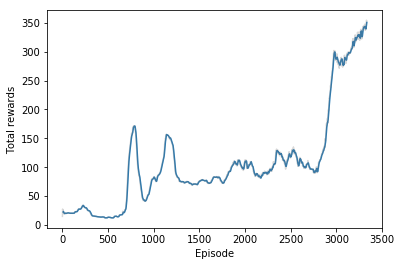

In [27]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

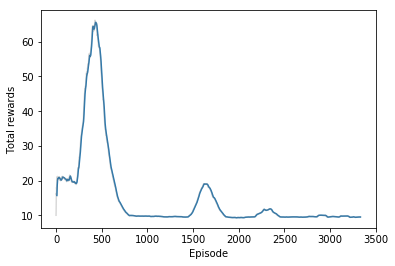

In [24]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

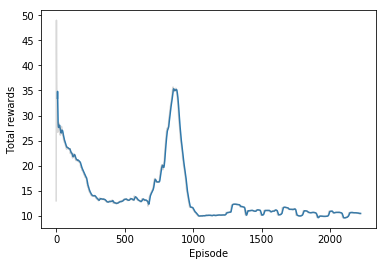

In [26]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

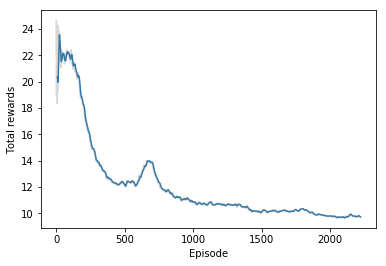

In [16]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

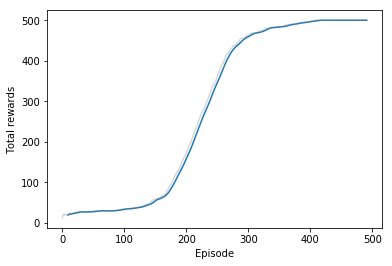

In [62]:
# eps, arr = np.array(episode_rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

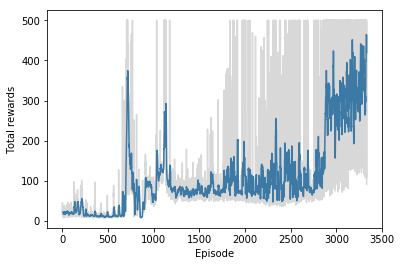

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'Total rewards')

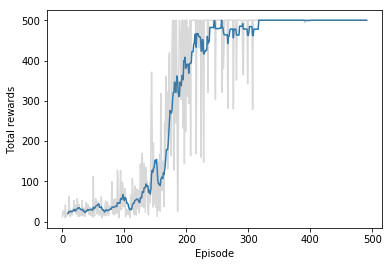

In [63]:
# eps, arr = np.array(rewards_list).T
# smoothed_arr = running_mean(arr, 10)
# plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
# plt.plot(eps, arr, color='grey', alpha=0.3)
# plt.xlabel('Episode')
# plt.ylabel('Total rewards')

In [19]:
eps, arr = np.array(gloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

In [ ]:
eps, arr = np.array(dloss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                print('total_reward: {}'.format(total_reward))
                break
                
env.close()

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.